In [2]:
from datetime import datetime
import itertools
import json
import math
import os

import geopandas
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import psycopg2
import scipy
from scipy.spatial import KDTree
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader, shape_utils, database_utils
from models import basic_ff
import run_models

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)
importlib.reload(shape_utils)
importlib.reload(database_utils)

from dotenv import load_dotenv
load_dotenv()

RUN_FOLDER = "../results/throwaway/"

# Get visual of adjacent buses actually working, also consider stops/schedule
# Look at where residuals are high for picking new features
# Try to get bearing/other stuff working for better feature of adjacent buses

In [3]:
train_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "train_traces.pkl")
test_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "test_traces.pkl")
with open(RUN_FOLDER + "kcm/deeptte_formatted/" + "config.json") as f:
    config = json.load(f)
gtfs_data = data_utils.merge_gtfs_files("." + config['gtfs_folder'])
tte_train_chunks, tte_test = data_utils.load_train_test_data(RUN_FOLDER + "kcm/deeptte_formatted/", 5)

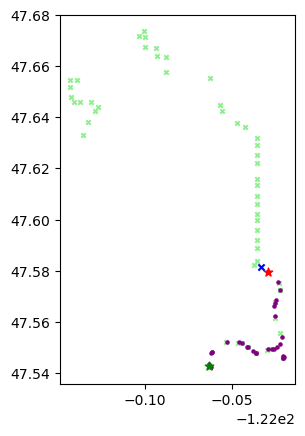

In [4]:
# Look at a single trip
shingle_data = test_traces[test_traces['shingle_id']==0].iloc[:]

plot_data = shingle_data.iloc[:]
fig, axes = plt.subplots(1,1)
shape_utils.plot_gtfs_trip(axes, plot_data['trip_id'].iloc[0], gtfs_data)
shape_utils.plot_gtfsrt_trip(axes, plot_data)

In [5]:
next_stops = shingle_data[['stop_lon','stop_lat','timeID_s']]
next_stops.columns = ["lon","lat","timeID_s"]
next_stops['Type'] = "Closest Scheduled Stop"
next_points = shingle_data[['lon','lat','timeID_s']]
next_points['Type'] = "Current Position"
plot_data = pd.concat([next_points, next_stops], axis=0)

In [6]:
px.set_mapbox_access_token(os.getenv('MAPBOX_TOKEN'))
fig = px.scatter_mapbox(
    plot_data,
    lon="lon",
    lat="lat",
    color="Type",
    animation_frame="timeID_s",
    animation_group="Type"
)
fig.show()

In [12]:
fig = px.scatter(
    plot_data,
    x="lon",
    y="lat",
    range_x=[np.min(plot_data['lon']), np.max(plot_data['lon'])],
    range_y=[np.min(plot_data['lat']), np.max(plot_data['lat'])],
    color="Type",
    animation_frame="timeID_s",
    animation_group="Type"
)
fig.show()

In [4]:
shingle = 1

# Filter on id and time
shingle_plot_data = train_traces[train_traces['shingle_id']==shingle]
adjacent_plot_data = train_traces[train_traces['locationtime']<=np.max(shingle_plot_data['locationtime'])]
adjacent_plot_data = adjacent_plot_data[adjacent_plot_data['locationtime']>=np.min(shingle_plot_data['locationtime'])]
adjacent_plot_data = adjacent_plot_data[adjacent_plot_data['shingle_id']!=np.min(shingle_plot_data['shingle_id'])]

# Filter on distance
points = np.array([adjacent_plot_data['lon'], adjacent_plot_data['lat']]).T.tolist()
query_points = np.array([shingle_plot_data['lon'], shingle_plot_data['lat']]).T.tolist()
distance = .001
flat_list = shape_utils.get_points_within_dist(points, query_points, distance)
adjacent_plot_data = adjacent_plot_data.iloc[flat_list]

# Join together for animation
shingle_plot_data['Trip Type'] = "Target"
adjacent_plot_data['Trip Type'] = "Adjacent"
plot_data = pd.concat([shingle_plot_data, adjacent_plot_data]).sort_values(['shingle_id','locationtime'])
len(plot_data)

332

In [ ]:
data = plot_data[['lon','lat','locationtime','shingle_id']]
data = data[data['shingle_id']==shingle].values

# Get unique IDs
IDs = np.unique(data[:, 3])

# Find the minimum and maximum times across all traces
t_min = np.min(data[:, 2])
t_max = np.max(data[:, 2])

# Set the time step for interpolation
dt = 1.0  # for example, 1 second

# Create a uniform time grid that covers the entire time range
t_grid = np.arange(t_min, t_max + dt, dt)

# Initialize arrays to store the interpolated x and y values for each trace
x_interp = np.zeros((len(t_grid), len(IDs)))
y_interp = np.zeros((len(t_grid), len(IDs)))

# Loop over each ID and interpolate x and y coordinates onto the uniform time grid
for i, ID in enumerate(IDs):
    # Extract x, y, and time values for the current trace
    trace_data = data[data[:, 3] == ID][:, :3]
    x = trace_data[:, 0]
    y = trace_data[:, 1]
    t = trace_data[:, 2]
    
    # Interpolate x and y coordinates onto the uniform time grid using cubic interpolation
    x_interp[:, i] = np.interp(t_grid, t, x, left=np.nan, right=np.nan)
    y_interp[:, i] = np.interp(t_grid, t, y, left=np.nan, right=np.nan)

# Combine the interpolated x, y, and time values to create a new set of points representing one observation per timestep, per trace
interpolated_data = np.column_stack((x_interp.flatten(), y_interp.flatten(), np.tile(t_grid, len(IDs)), np.repeat(IDs, len(t_grid))))
plot_data = pd.DataFrame(interpolated_data, columns=['lon','lat','locationtime','shingle_id'])

In [6]:
# px.set_mapbox_access_token(os.getenv('MAPBOX_TOKEN'))
fig = px.scatter(
    plot_data.sort_values('locationtime'),
    x="lon",
    y="lat",
    range_x=[np.min(plot_data['lon']), np.max(plot_data['lon'])],
    range_y=[np.min(plot_data['lat']), np.max(plot_data['lat'])],
    color="shingle_id",
    # symbol="Trip Type",
    animation_frame="locationtime",
    animation_group="shingle_id"
)
fig.show()

In [7]:
px.set_mapbox_access_token(os.getenv('MAPBOX_TOKEN'))
fig = px.scatter_mapbox(
    plot_data,
    lon="lon",
    lat="lat",
    color="shingle_id",
    animation_frame="locationtime",
    animation_group="shingle_id"
)
fig.show()

In [ ]:
point_obs = train_traces[['lon','lat','speed_m_s','bearing']].values
# Get component of speeds in x and y axes: soh cah toa
x_speed_m_s = np.sin(point_obs[:,3]) * point_obs[:,2]
y_speed_m_s = np.cos(point_obs[:,3]) * point_obs[:,2]
# https://stackoverflow.com/questions/36013063/what-is-the-purpose-of-meshgrid-in-python-numpy
# For X, only x coordinate indexes diff values. For Y, only y coordinate indexes diff values
x = np.linspace(np.min(train_traces['lon']), np.max(train_traces['lon']), 1000)
y = np.linspace(np.min(train_traces['lat']), np.max(train_traces['lat']), 1000)
Y, X = np.meshgrid(x, y)
# lon_bins = np.digitize(point_obs[:,0], x) - 1
# lat_bins = np.digitize(point_obs[:,1], y) - 1

In [ ]:
# The bins are off by one dimension from the gridlines; add back a very small extra bin
xbins = np.append(x, x[-1]+.0000001)
ybins = np.append(y, y[-1]+.0000001)
# Gather speeds by their 2d lat/lon bins
x_speed_hist, x_edges, y_edges = np.histogram2d(point_obs[:,0], point_obs[:,1], bins=[xbins,ybins], weights=x_speed_m_s, normed=False)
y_speed_hist, x_edges, y_edges = np.histogram2d(point_obs[:,0], point_obs[:,1], bins=[xbins,ybins], weights=y_speed_m_s, normed=False)
count_hist, x_edges, y_edges = np.histogram2d(point_obs[:,0], point_obs[:,1], bins=[xbins,ybins], normed=False)
# Get the average in each 2d bin
x_speed_hist = x_speed_hist.T / np.maximum(1, count_hist.T)
y_speed_hist = y_speed_hist.T / np.maximum(1, count_hist.T)
x_speed_hist[x_speed_hist==0] = .000001
y_speed_hist[y_speed_hist==0] = .000001
count_hist = count_hist.T

In [ ]:
fig = px.imshow(count_hist)
fig.show()

In [ ]:
# Create streamline figure
fig = ff.create_streamline(x, y, x_speed_hist, y_speed_hist, density=2, arrow_scale=.005)
fig.show()

In [ ]:
# Could filter on bearing
# Could weight mean by distance and time
# Could use pace, percentiles, or schedule deviation

In [ ]:
avg_shingle_speeds = train_traces.groupby('shingle_id').mean(numeric_only=True)['speed_m_s'].reset_index()
t = pd.merge(avg_shingle_speeds, adjacent_shingles, left_on="shingle_id", right_on="pred_shingle")
print(len(avg_shingle_speeds), len(adjacent_shingles))
t

In [ ]:
logx = np.log(t['avg_adj_speed_m_s'])
logy = np.log(t['speed_m_s'])

# Fit polynomial to the data
z = np.polyfit(logx, y=logy, deg=2)
x_val = np.arange(-5,4,.1)
p = np.poly1d(z)
y_val = p(x_val)

# Get metrics
# R2: variance explained by model / total variance
SSR = np.sum((logy - p(logx))**2)
SST = np.sum((logy - np.mean(logy))**2)
print(1 - (SSR/SST))
sns.scatterplot(x=logx, y=logy, marker=".")
sns.scatterplot(x=x_val, y=y_val)

In [ ]:
# Fit polynomial to the data
z = np.polyfit(x=t['avg_adj_speed_m_s'], y=t['speed_m_s'], deg=2)
x_val = np.arange(0,35,.1)
p = np.poly1d(z)
y_val = p(x_val)

# Get metrics
# R2: variance explained by model / total variance
SSR = np.sum((t['speed_m_s'] - p(t['avg_adj_speed_m_s']))**2)
SST = np.sum((t['speed_m_s'] - np.mean(t['speed_m_s']))**2)
print(1 - (SSR/SST))
sns.scatterplot(x=t['avg_adj_speed_m_s'], y=t['speed_m_s'], marker=".")
sns.scatterplot(x=x_val, y=y_val)